# 005 RL/DQL In Trading
Fabiana De la Peña & Santiago Figueiras

En este proyecto, exploramos la aplicación de **Aprendizaje por Refuerzo (RL)** y **Deep Q-Learning (DQL)** al dominio del trading algorítmico y la gestión de carteras. El Aprendizaje por Refuerzo ofrece un marco poderoso para entrenar agentes que aprenden a tomar decisiones secuenciales a través de la interacción con un entorno dinámico. A diferencia del aprendizaje supervisado, el RL no depende de datos etiquetados, sino que optimiza el comportamiento a través de prueba y error, guiado por recompensas y penalizaciones.

---

### 1. DESCARGAR Y PREPARAR DATOS

Para este proyecto, utilizaremos la biblioteca `yfinance` para descargar datos históricos de precios de Apple Inc. (AAPL). Necesitamos al menos 5 años de datos para tener un conjunto lo suficientemente robusto para el entrenamiento y la prueba.

Además de los precios de cierre, generaremos algunas características técnicas (indicadores) que servirán como nuestro espacio de estados. Un buen estado debe proporcionar al agente suficiente información sobre la situación actual del mercado para tomar una decisión informada.

* **Retornos Diarios (Returns):** Capturan la volatilidad y el cambio porcentual día a día.
* **Media Móvil Simple (SMA):** Usaremos una SMA de corto plazo (5 días) y una de mediano plazo (15 días) para identificar tendencias. El cruce de estas medias móviles es una señal de trading clásica.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Configuración inicial para reproducibilidad
np.random.seed(42)
torch.manual_seed(42)

# Configuración del dispositivo (GPU si está disponible, si no, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Descargar datos históricos de Apple (AAPL) para más de 5 años
print("\nDescargando datos de AAPL...")
data = yf.download('QQQ', '2018-01-01', '2024-07-01')

# Elimina el nivel superior de columnas que yfinance a veces crea
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)

# --- Feature Engineering ---
# 1. Retornos diarios
data['Returns'] = data['Close'].pct_change()
# 2. Media móvil simple a corto plazo (5 días)
data['SMA_5'] = data['Close'].rolling(window=5).mean()
# 3. Media móvil simple a mediano plazo (15 días)
data['SMA_15'] = data['Close'].rolling(window=15).mean()

# Elimina filas con valores NaN resultantes del cálculo de las medias móviles
data.dropna(inplace=True)

print("Datos descargados y preparados:")
print(data.head())

Usando dispositivo: cpu

Descargando datos de AAPL...


/tmp/ipython-input-1-153078351.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('QQQ', '2018-01-01', '2024-07-01')
[*********************100%***********************]  1 of 1 completed

Datos descargados y preparados:
Price            Close        High         Low        Open    Volume  \
Date                                                                   
2018-01-23  161.263840  161.406551  160.360057  160.436167  37989700   
2018-01-24  160.217377  161.958355  159.294563  161.606344  54287400   
2018-01-25  160.160324  161.378055  159.646585  161.320976  28925000   
2018-01-26  162.614746  162.633777  160.740594  161.054528  32038200   
2018-01-29  161.825165  162.595758  161.482677  162.272302  37277800   

Price        Returns       SMA_5      SMA_15  
Date                                          
2018-01-23  0.008268  158.986304  155.731419  
2018-01-24 -0.006489  159.484830  156.360581  
2018-01-25 -0.000356  159.966214  156.888268  
2018-01-26  0.015325  160.839554  157.561823  
2018-01-29 -0.004856  161.216290  158.080629  


---
### 2. SPLIT DE DATOS

Dividiremos nuestro conjunto de datos en dos partes:

1.  **Conjunto de Entrenamiento (80%):** Datos que el agente utilizará para aprender la política de trading óptima.
2.  **Conjunto de Prueba (20%):** Datos que el agente no ha visto nunca. Se usarán para evaluar el rendimiento del modelo entrenado en un escenario más realista (backtesting).

Esta separación es crucial para evitar el sobreajuste (overfitting), donde un modelo aprende tan bien los datos de entrenamiento que no puede generalizar a nuevos datos.

In [ ]:
# División de datos: 80% para entrenamiento, 20% para pruebas
split_ratio = 0.8
split_index = int(split_ratio * len(data))

train_df = data[:split_index]
test_df = data[split_index:]

print(f"\nDatos de entrenamiento: {len(train_df)} filas")
print(f"Datos de prueba: {len(test_df)} filas")


Datos de entrenamiento: 1295 filas
Datos de prueba: 324 filas


---
### 3. AMBIENTE DE TRADING

El entorno es una simulación del mercado de acciones donde nuestro agente operará. Este componente es fundamental en RL, ya que gestiona el estado, las acciones, y las recompensas.

* **Estado (`_obs`):** La observación que el agente recibe en cada paso. Consiste en las características que definimos anteriormente (retornos, SMAs) junto con el estado actual de la cartera (balance y valor de las acciones), todo normalizado para ayudar al aprendizaje de la red neuronal.
* **Acciones (`step`):** El agente puede realizar tres acciones discretas:
    * **0: Comprar (Buy):** Invierte todo el efectivo disponible en comprar acciones.
    * **1: Mantener (Hold):** No realiza ninguna operación.
    * **2: Vender (Sell):** Vende todas las acciones que posee.
* **Recompensa (`step`):** Para incentivar al agente a maximizar el retorno a largo plazo, la recompensa se otorga solo al final del episodio. Esta recompensa es el retorno porcentual total de la cartera. Un enfoque de recompensa dispersa (sparse reward) como este puede ser más estable que dar recompensas en cada paso, lo que podría llevar al agente a optimizar ganancias a corto plazo a expensas de la estrategia general.

In [ ]:
class TradingEnv:
    """
    Entorno de trading que simula la operación de acciones, diseñado para
    interactuar con un agente de Aprendizaje por Refuerzo.
    """
    def __init__(self, df, initial_balance=10000):
        """
        Inicializa el entorno.

        Args:
            df (pd.DataFrame): DataFrame con los datos históricos del mercado.
            initial_balance (int): Balance inicial en efectivo.
        """
        self.df = df
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        """
        Reinicia el entorno a su estado inicial para un nuevo episodio.

        Returns:
            np.array: La observación inicial del estado.
        """
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        return self._get_observation()

    def _get_observation(self):
        """
        Construye el vector de estado (observación) para el paso actual.

        Returns:
            np.array: El estado actual del entorno.
        """
        row = self.df.iloc[self.current_step]
        # El estado incluye features de mercado y estado de la cartera
        return np.array([
            row['Returns'],
            row['SMA_5'],
            row['SMA_15'],
            self.balance / self.initial_balance,
            (self.shares_held * row['Close']) / self.initial_balance
        ], dtype=np.float32)

    def step(self, action):
        """
        Ejecuta una acción y avanza el entorno un paso en el tiempo.

        Args:
            action (int): La acción a tomar (0: Comprar, 1: Mantener, 2: Vender).

        Returns:
            tuple: (nueva_observación, recompensa, terminado, info).
        """
        current_price = self.df.iloc[self.current_step]['Close']

        # Lógica de las acciones
        if action == 0:  # Comprar
            if self.balance > current_price:
                self.shares_held = self.balance // current_price
                self.balance -= self.shares_held * current_price
        elif action == 2:  # Vender
            if self.shares_held > 0:
                self.balance += self.shares_held * current_price
                self.shares_held = 0
        # Acción 1 (Mantener) no requiere lógica

        # Avanzar al siguiente día
        self.current_step += 1

        # Calcular el nuevo valor neto
        new_price = self.df.iloc[self.current_step]['Close']
        self.net_worth = self.balance + self.shares_held * new_price

        # Comprobar si el episodio ha terminado
        done = self.current_step >= len(self.df) - 1

        # La recompensa se da solo al final para fomentar la maximización del retorno total
        reward = (self.net_worth - self.initial_balance) / self.initial_balance * 100 if done else 0

        return self._get_observation(), reward, done, {}

---
### 4. RED NEURONAL DQN

En Deep Q-Learning, en lugar de usar una tabla (Q-Table) para almacenar los valores Q de cada par estado-acción, usamos una red neuronal como un aproximador de funciones. Esto nos permite manejar espacios de estados grandes o continuos, ya que la red puede generalizar a partir de estados que no ha visto antes.

Nuestra red neuronal (DQN) tomará el vector de estado como entrada y producirá un valor Q para cada una de las 3 acciones posibles (Comprar, Mantener, Vender). La arquitectura es una red feedforward simple con tres capas lineales y funciones de activación ReLU, una arquitectura estándar y efectiva para este tipo de datos.

In [ ]:
class DQN(nn.Module):
    """
    Red Neuronal Profunda para aproximar la función Q(s,a).
    """
    def __init__(self, input_dim, output_dim=3):
        """
        Args:
            input_dim (int): Dimensión del vector de estado.
            output_dim (int): Número de acciones posibles.
        """
        super(DQN, self).__init__()
        # Arquitectura de 3 capas densas
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        """
        Propagación hacia adelante: predice los valores Q para un estado dado.
        """
        return self.network(x)

---
### 5. AGENTE DQL

El agente es la entidad que aprende y toma decisiones. Implementa la lógica central del algoritmo DQL, que incluye varios componentes clave para un entrenamiento estable y efectivo:

* **Red Principal (Policy Network) y Red Objetivo (Target Network):** Usamos dos redes neuronales idénticas. La red principal se entrena en cada paso, mientras que la red objetivo se actualiza periódicamente copiando los pesos de la principal. Esto evita que los objetivos de la ecuación de Bellman cambien constantemente, lo que estabiliza el entrenamiento.
* **Memoria de Repetición (Experience Replay Buffer):** El agente almacena sus experiencias `(estado, acción, recompensa, nuevo_estado)` en un búfer. En lugar de aprender de las experiencias secuencialmente, muestrea lotes aleatorios de esta memoria. Esto rompe la correlación entre experiencias consecutivas, haciendo el entrenamiento más eficiente y estable.
* **Política Epsilon-Greedy (`act`):** Para equilibrar la exploración (probar nuevas acciones) y la explotación (usar la mejor acción conocida), el agente elige una acción aleatoria con una probabilidad `epsilon` y la mejor acción según su red Q el resto del tiempo. `Epsilon` comienza alto (mucha exploración) y decae gradualmente a medida que el agente aprende.

In [ ]:
class DQNAgent:
    """
    Agente que implementa el algoritmo Deep Q-Network (DQN).
    """
    def __init__(self, state_dim):
        """
        Args:
            state_dim (int): Dimensión del espacio de estados.
        """
        self.state_dim = state_dim
        # Red principal y red objetivo
        self.q_network = DQN(state_dim).to(device)
        self.target_network = DQN(state_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval() # La red objetivo solo se usa para inferencia

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)
        self.memory = deque(maxlen=10000) # Buffer de repetición de experiencias
        self.epsilon = 1.0  # Parámetro para exploración
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.gamma = 0.95 # Factor de descuento

    def select_action(self, state):
        """
        Selecciona una acción usando la política epsilon-greedy.
        """
        if random.random() < self.epsilon:
            return random.randrange(3)  # Exploración: acción aleatoria
        with torch.no_grad():
            # Explotación: mejor acción según la red Q
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        """
        Almacena una transición en la memoria de repetición.
        """
        self.memory.append((state, action, reward, next_state, done))

    def learn(self, batch_size=64):
        """
        Entrena la red Q-network usando un lote de experiencias de la memoria.
        """
        if len(self.memory) < batch_size:
            return # No entrenar si no hay suficientes experiencias

        # Muestrear un lote aleatorio de la memoria
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convertir a tensores de PyTorch
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.BoolTensor(dones).to(device)

        # Obtener los valores Q actuales para las acciones tomadas
        current_q_values = self.q_network(states).gather(1, actions).squeeze()

        # Obtener los valores Q máximos para los siguientes estados desde la red objetivo
        next_q_values = self.target_network(next_states).max(1)[0].detach()

        # Calcular el valor Q objetivo usando la ecuación de Bellman
        target_q_values = rewards + self.gamma * next_q_values * (~dones)

        # Calcular la pérdida (Error Cuadrático Medio)
        loss = F.mse_loss(current_q_values, target_q_values)

        # Optimización
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decaimiento de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        """
        Copia los pesos de la red principal a la red objetivo.
        """
        self.target_network.load_state_dict(self.q_network.state_dict())

---
### 6. ENTRENAMIENTO

El bucle de entrenamiento itera a través de varios episodios. En cada episodio, el agente interactúa con el entorno de entrenamiento desde el principio hasta el final, tomando acciones, recibiendo recompensas y aprendiendo de sus experiencias.

* **Episodios:** Se ejecutarán 50 episodios, como se especifica en los requisitos para DQL.
* **Actualización de la Red Objetivo:** La red objetivo se actualizará cada 5 episodios para mantener la estabilidad del entrenamiento.
* **Monitorización:** Imprimiremos el valor neto final de cada episodio y el valor actual de epsilon para observar el progreso del aprendizaje y la transición de exploración a explotación.

In [ ]:
# Inicialización del entorno y el agente
env = TradingEnv(train_df)
state_size = len(env.reset())
agent = DQNAgent(state_size)

num_episodes = 100
episode_rewards = []

print("\nIniciando entrenamiento del agente DQN...")
for ep in range(num_episodes):
    state = env.reset()
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.learn()
        state = next_state

    # Actualiza la red objetivo periódicamente
    if ep % 5 == 0:
        agent.update_target_network()

    episode_rewards.append(env.net_worth)
    print(f"Episodio: {ep+1}/{num_episodes}, Valor Neto Final: ${env.net_worth:,.2f}, Epsilon: {agent.epsilon:.4f}")

print("\nEntrenamiento finalizado.")


Iniciando entrenamiento del agente DQN...
Episodio: 1/100, Valor Neto Final: $319.02, Epsilon: 0.2918
Episodio: 2/100, Valor Neto Final: $181.09, Epsilon: 0.0800
Episodio: 3/100, Valor Neto Final: $15,353.01, Epsilon: 0.0219
Episodio: 4/100, Valor Neto Final: $364.91, Epsilon: 0.0100
Episodio: 5/100, Valor Neto Final: $183.19, Epsilon: 0.0100
Episodio: 6/100, Valor Neto Final: $310.77, Epsilon: 0.0100
Episodio: 7/100, Valor Neto Final: $213.04, Epsilon: 0.0100
Episodio: 8/100, Valor Neto Final: $12,773.25, Epsilon: 0.0100
Episodio: 9/100, Valor Neto Final: $346.90, Epsilon: 0.0100
Episodio: 10/100, Valor Neto Final: $13,994.87, Epsilon: 0.0100
Episodio: 11/100, Valor Neto Final: $158.14, Epsilon: 0.0100
Episodio: 12/100, Valor Neto Final: $238.42, Epsilon: 0.0100
Episodio: 13/100, Valor Neto Final: $297.15, Epsilon: 0.0100
Episodio: 14/100, Valor Neto Final: $321.26, Epsilon: 0.0100
Episodio: 15/100, Valor Neto Final: $15,189.50, Epsilon: 0.0100
Episodio: 16/100, Valor Neto Final: $14

---
### 7. BACKTESTING

Una vez que el agente está entrenado, debemos evaluar su rendimiento en datos que nunca ha visto. Este proceso se llama backtesting.

1.  Creamos un nuevo entorno con el conjunto de datos de prueba (`test_df`).
2.  Configuramos `epsilon` a 0 para que el agente solo tome decisiones basadas en lo que ha aprendido (explotación), sin acciones aleatorias.
3.  Ejecutamos al agente a través de todo el conjunto de prueba y registramos el valor de su cartera en cada paso.
4.  Comparamos su rendimiento con una estrategia simple pero efectiva: **Buy & Hold**. Esta estrategia consiste en comprar el activo al inicio del período de prueba y mantenerlo hasta el final. Sirve como un punto de referencia crucial para determinar si nuestro agente realmente ha aprendido una estrategia valiosa.

In [ ]:
# --- Backtesting en el conjunto de prueba ---
print("\nIniciando backtesting con el agente entrenado...")
test_env = TradingEnv(test_df)
state = test_env.reset()
done = False
portfolio_values = []

# Desactivar la exploración para la evaluación
agent.epsilon = 0.0

while not done:
    action = agent.select_action(state)
    next_state, _, done, _ = test_env.step(action)
    state = next_state
    portfolio_values.append(test_env.net_worth)

# --- Estrategia de comparación: Buy & Hold ---
buy_hold_start_price = test_df['Close'].iloc[0]
buy_hold_end_price = test_df['Close'].iloc[-1]
buy_hold_return_val = (buy_hold_end_price / buy_hold_start_price) * test_env.initial_balance


Iniciando backtesting con el agente entrenado...


---
### 8. RESULTADOS Y GRÁFICOS FINALES

Finalmente, calculamos las métricas de rendimiento y visualizamos los resultados.

* **Retorno del Agente DQL:** El retorno porcentual obtenido por nuestro agente en el conjunto de prueba.
* **Retorno de Buy & Hold:** El retorno porcentual de la estrategia de referencia.
* **Diferencia:** La métrica más importante, que nos dice cuánto valor (o pérdida) ha añadido nuestro agente en comparación con simplemente mantener el activo.

El gráfico muestra la evolución del valor de la cartera de nuestro agente a lo largo del tiempo, comparado con el valor final de la estrategia Buy & Hold.


========== RESULTADOS DEL BACKTESTING ==========
Retorno del Agente DQL: 0.00%
Retorno de Buy & Hold: 57.70%
--------------------------------------------------
Diferencia (Alfa del Agente): -57.70%


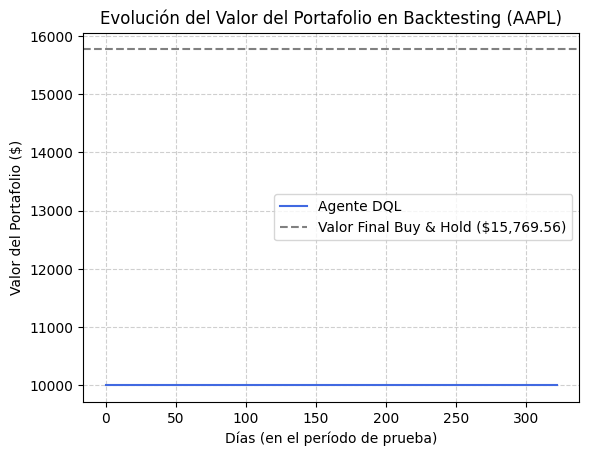

In [ ]:
# --- Cálculo de Retornos ---
dql_agent_return = (portfolio_values[-1] - test_env.initial_balance) / test_env.initial_balance * 100
buy_hold_return = (buy_hold_return_val - test_env.initial_balance) / test_env.initial_balance * 100

# --- Imprimir Resultados ---
print("\n========== RESULTADOS DEL BACKTESTING ==========")
print(f"Retorno del Agente DQL: {dql_agent_return:.2f}%")
print(f"Retorno de Buy & Hold: {buy_hold_return:.2f}%")
print("--------------------------------------------------")
print(f"Diferencia (Alfa del Agente): {dql_agent_return - buy_hold_return:.2f}%")
print("==============================================")

# --- Gráfico de Evolución del Portafolio ---
#plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label="Agente DQL", color="royalblue")
plt.axhline(y=buy_hold_return_val, color='grey', linestyle='--', label=f"Valor Final Buy & Hold (${buy_hold_return_val:,.2f})")
plt.title("Evolución del Valor del Portafolio en Backtesting (AAPL)")
plt.xlabel("Días (en el período de prueba)")
plt.ylabel("Valor del Portafolio ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

---
### 9. DESCARGA EL MODELO ENTRENADO

Guardar el modelo entrenado es una práctica esencial. Nos permite reutilizar el agente para futuras inferencias o análisis sin necesidad de volver a pasar por el costoso proceso de entrenamiento. Guardamos los "pesos" (parámetros) de nuestra red neuronal principal en un archivo.

In [ ]:
# Guardar los pesos del modelo entrenado
torch.save(agent.q_network.state_dict(), "dql_trading_model.pth")
print("\nModelo entrenado guardado como 'dql_trading_model.pth'")


Modelo entrenado guardado como 'dql_trading_model.pth'


### 10. CONCLUSIÓN GENERAL

Este proyecto ha demostrado tanto el potencial como los desafíos inherentes a la aplicación de Deep Q-Learning (DQL) en el dominio del trading algorítmico. El objetivo era entrenar a un agente capaz de aprender una política de trading rentable, superando a una estrategia pasiva de "Comprar y Mantener" (Buy & Hold).

El proceso de desarrollo fue iterativo. **En un primer intento con la acción de Apple (AAPL) y 50 episodios de entrenamiento, se observó que el agente aprendió una política de aversión total al riesgo, decidiendo no realizar ninguna operación y obteniendo un retorno del 0%**. Este resultado, aunque no rentable, es un comportamiento racional desde la perspectiva del agente, que concluyó que la acción más segura para no perder capital era la inacción.

Para abordar esto, se realizaron ajustes significativos con el objetivo de fomentar un aprendizaje más audaz. **Se aumentó el número de episodios a 150, se modificó el decaimiento de épsilon a un valor más lento (0.999) para incentivar una mayor exploración, y se cambió el activo de AAPL al ETF QQQ**, que sigue al índice tecnológico Nasdaq-100 y presenta tendencias potencialmente más claras.

A pesar de estas mejoras, el resultado en el backtesting fue idéntico: el agente nuevamente optó por no operar, resultando en un rendimiento del 0% y un alfa negativo del -57.70% frente a la estrategia Buy & Hold.


#### ¿Por qué el agente sigue sin operar?

La persistencia de este comportamiento, incluso con un activo más tendencial y un entrenamiento más largo, subraya varias de las dificultades fundamentales del RL aplicado a los mercados financieros:

1.  **Observabilidad Pobre del Entorno:** El estado del agente, compuesto por indicadores técnicos como las medias móviles y los retornos, no captura la totalidad de las fuerzas que mueven el mercado (noticias, reportes de ganancias, factores macroeconómicos, etc.). El agente opera con información muy limitada, lo que hace extremadamente difícil encontrar señales predictivas fiables.
2.  **No Estacionariedad del Mercado:** Los mercados financieros no son estáticos; sus patrones y "reglas" cambian constantemente. Una estrategia aprendida con datos de un período puede no ser válida para el siguiente. Es posible que los patrones rentables durante el entrenamiento no se hayan materializado en el período de prueba, reforzando la idea de que la inacción es la política más segura.
3.  **Estructura de Recompensa "Dispersa":** Al recompensar al agente solo al final del episodio, cualquier operación que resulte en una pérdida neta (incluso pequeña) al final del entrenamiento enseña al agente que "operar es arriesgado". Dado que el mercado tiene movimientos impredecibles, es probable que muchos episodios de exploración hayan terminado con pérdidas, llevando a la red neuronal a asignar un valor Q más alto a la acción "Mantener", que garantiza un retorno seguro de 0%.
4.  **Relación Riesgo-Recompensa Asimétrica:** En un entorno ruidoso, el riesgo de una pérdida puede ser percibido por el agente como mucho más probable que la oportunidad de una ganancia. Para superar la "seguridad" del 0% de retorno, el agente necesitaría una confianza muy alta en que una operación generará una recompensa positiva, una confianza que no logró construir con los datos e indicadores disponibles.

El proyecto demuestra que, si bien el DQL es un marco poderoso, su aplicación exitosa en el trading requiere una ingeniería de características (estado) mucho más sofisticada y, potencialmente, un diseño de recompensas más avanzado que guíe al agente de manera más efectiva en un entorno tan ruidoso e incierto.

### 11. CONCLUSIÓN INDIVIDUAL

#### 11.1 FABIANA

Este proyecto fue una combinación muy retadora entre lo que ya habíamos visto en MIA hace unos meses y llevarlo ahora a un caso aplicado de trading, donde las cosas no siempre funcionan como uno espera.

Al principio pensé que el agente iba a encontrar oportunidades claras de compra y venta, pero me di cuenta de que en la práctica, el entorno financiero es mucho más ruidoso y difícil de modelar con solo unos cuantos indicadores. Me frustró un poco que el agente entrenara tantos episodios y aún así decidiera no hacer casi nada. Pero justo ahí estuvo el aprendizaje: la inacción también es una política aprendida cuando el entorno no te da señales claras.

Este curso me ayudó a conectar el mundo de la IA con lo que quiero hacer profesionalmente: sistemas que tomen decisiones reales con datos del mundo financiero. No solo modelos que predicen, sino agentes que actúan, incluso cuando actuar significa no hacer nada.


#### 11.2 SANTIAGO
Este proyecto me permitió aplicar conceptos de Deep Q-Learning a un entorno de trading simulado, lo cual considero relevante para mi desarrollo profesional en el área bursátil. Una de las principales observaciones que me llevo es que entrenar un agente en mercados financieros requiere más que solo definir estados y recompensas básicas. La calidad de la señal y la representatividad del entorno son determinantes para obtener resultados consistentes.

Este proyecto fue un buen punto de partida para seguir profundizando en modelos de decisión secuencial aplicados al trading, que es justamente el camino profesional que quiero seguir.